# Proyecto Final 
------

Por Ramón Escobar para Ciencia de Datos en Python I (Abril 2021)

## Carga de datos y Train-Test Split

In [1]:
#Librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

In [2]:
data = np.load('proyecto_training_data.npy', allow_pickle = False)

In [3]:
data.shape

(1460, 6)

In [4]:
pct_test = int(data.shape[0]*0.8)
pct_train = int(data.shape[0]*0.2)
np.random.shuffle(data)

train, test = data[:pct_test], data[:pct_train]
train.shape, test.shape

((1168, 6), (292, 6))

## Descriptivos de datos

In [5]:
train = pd.DataFrame(train, 
             columns = ['SalePrice', 'OverallQual','1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'])

test = pd.DataFrame(test, 
             columns = ['SalePrice','OverallQual', '1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'])

In [6]:
train.describe()

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,962.000000
mean,181617.352740,6.136986,1162.180651,6.545377,1971.019692,70.343035
std,78011.766449,1.378026,385.219457,1.628683,30.667336,24.866947
min,34900.000000,1.000000,372.000000,3.000000,1872.000000,21.000000
25%,131000.000000,5.000000,882.000000,5.000000,1953.000000,59.250000
50%,164995.000000,6.000000,1086.000000,6.000000,1972.500000,69.000000
75%,215000.000000,7.000000,1383.000000,7.000000,2001.000000,80.000000
max,745000.000000,10.000000,4692.000000,14.000000,2010.000000,313.000000


## Histogramas

In [7]:
def hist_dimensions(data, dimension):
    plot = sns.displot(data = data, x = dimension)
    plt.title(dimension)
    plt.xlabel(dimension, fontsize = 12)
    plt.ylabel('Conteo', fontsize = 12)
    plt.show()

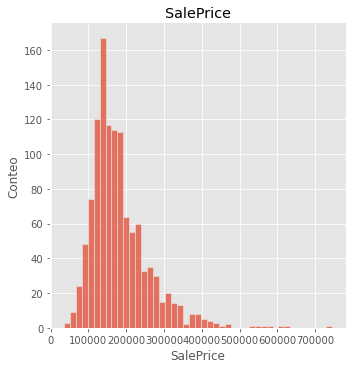

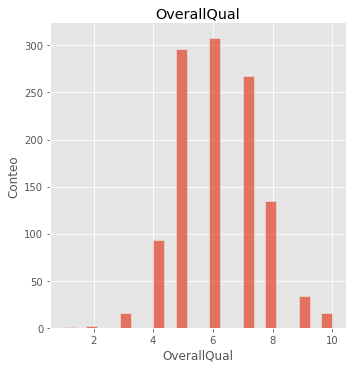

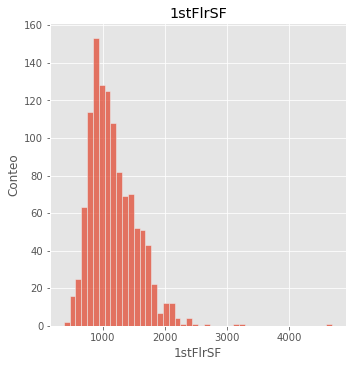

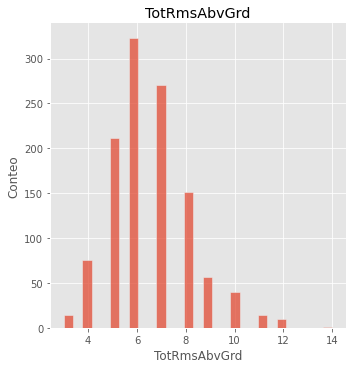

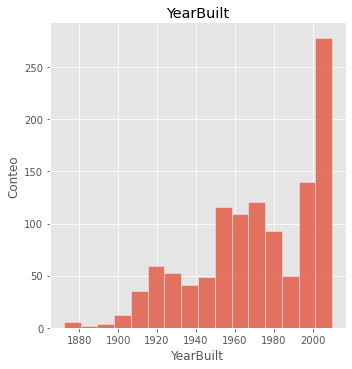

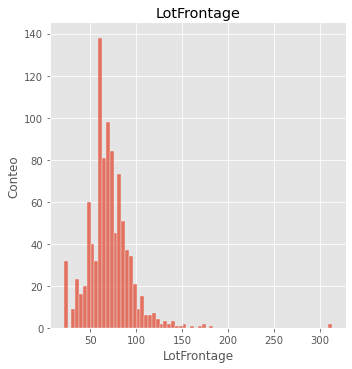

In [8]:
for i in train.columns.to_list():
    hist_dimensions(train, i)

## Correlaciones

In [9]:
def correlations_xy(data, x_dim, y_dim):
    corr = (pd.DataFrame(data[[x_dim, y_dim]]).corr().iloc[0,1])
    plt.figure(figsize = (7,3))
    plt.scatter(data = data, x = x_dim, y = y_dim)
    plt.title(str(x_dim)+' vs '+ str(y_dim) + ' | Corr:'+str((round(corr,4))), fontsize = 12)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.show()

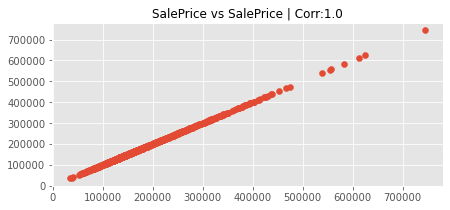

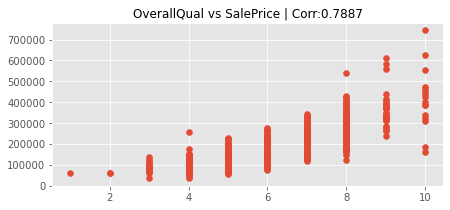

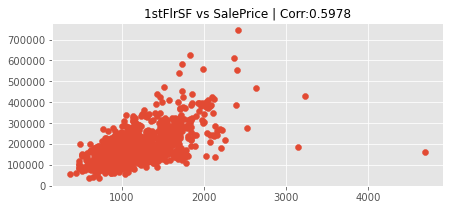

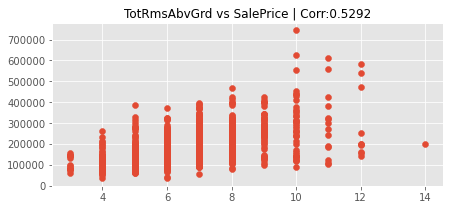

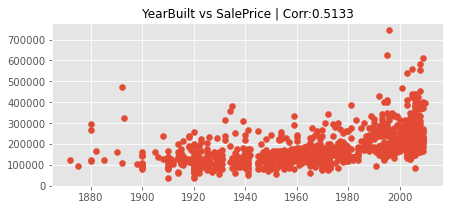

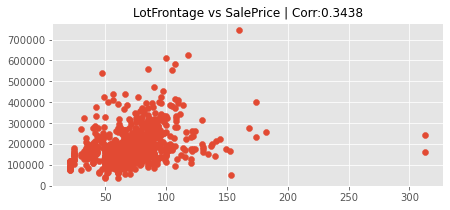

In [18]:
for i in train.columns.to_list():
    correlations_xy(train, i, 'SalePrice')
        

Basado en esta información, OverallQual 1stFlrFS son las candidatas a ser las variables con mayor poder predictivo

## Regresión

### Vectorización

In [19]:
class univ_linear_reg():
    def __init__(self, x, y, epochs = 1000, imprimir_error_cada=100, learning_rate = 0.001 ):
        self.vect_ones = np.ones_like(x).reshape(-1,1)
        self.xr = np.reshape(x,(-1,1))
        self.xr = np.hstack([self.xr,self.vect_ones])
        self.yr = np.reshape(y, (-1,1))
        
        #inicializando betas
        self.b0 = np.random.randn()
        self.b1 = np.random.randn()
        self.betas = np.array([[self.b1],[self.b0]])
    
        #inicilizando almacenamiento de errores y modelo
        self.errors = []
        self.models = {}
        
        for i in range(0, epochs):
            #Predicciones
            self.y_pred = np.dot(self.xr, self.betas)

            #Calculo del error
            self.e = 1/(2*self.yr.shape[0]) * sum((self.yr - self.y_pred)**2)
            self.errors.append(self.e[0])

            #calculando gradientes
            self.gradient = 1/self.yr.shape[0]*sum((self.y_pred - self.yr)*self.xr)
            self.mult_gradient = (learning_rate*self.gradient)
            self.mult_gradient = self.mult_gradient.reshape((-1,1))

            #Actualizando Betas
            self.betas = self.betas - self.mult_gradient

            self.models[i] = [self.betas, self.y_pred, self.yr]

            #Imprimiendo resultados cada n veces
            if i%imprimir_error_cada==0:
                print('Iteración: ', i)
                print('Error: ',self.e[0])
                print("")
        
    def trained_models(self):
        return self.models , np.array(self.errors)
    
    @staticmethod
    def error_plot(errors):
        plt.figure(figsize = (7,3))
        plt.plot(errors)
        plt.title("Errores del modelo", fontsize = 12)
        plt.xlabel("Epoch", fontsize = 10)
        plt.ylabel("Errores")
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)
        plt.show()
        
    @staticmethod
    def model_plot(models_t,n):
        for k in models_t.keys():
            if k%n == 0:
                plt.figure(figsize = (6,4))
                plt.plot(models_t[k][1], color ='b')
                plt.scatter(np.arange(len(models_t[k][1])),models_t[k][2])
                plt.title("Modelo #"+str(k), fontsize = 12)
                plt.xlabel("X", fontsize = 10)
                plt.ylabel("Y", fontsize = 10)
                plt.xticks(fontsize = 10)
                plt.yticks(fontsize = 10)
                plt.show()

## Pruebas de modelo

In [20]:
x = np.linspace(0, 100, 100)
y = x*2

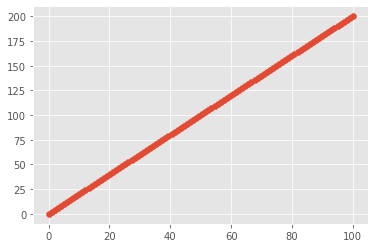

In [21]:
plt.scatter(x,y)

In [41]:
model = univ_linear_reg(x, y, 20000,2000,0.0000001)
modelos, errores = model.trained_models()

Iteración:  0
Error:  4783.8368854171495

Iteración:  2000
Error:  1251.896248463675

Iteración:  4000
Error:  327.6188166658765

Iteración:  6000
Error:  85.74363782015293

Iteración:  8000
Error:  22.447055287621396

Iteración:  10000
Error:  5.882902085850476

Iteración:  12000
Error:  1.548209727956332

Iteración:  14000
Error:  0.4138584325054492

Iteración:  16000
Error:  0.11700791059853652

Iteración:  18000
Error:  0.039323887578042026



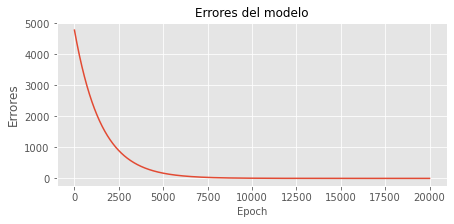

In [42]:
univ_linear_reg.error_plot(errores)

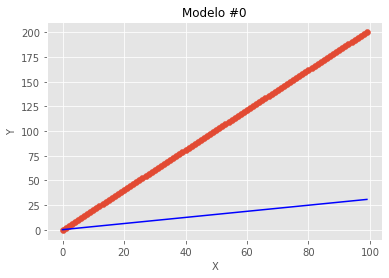

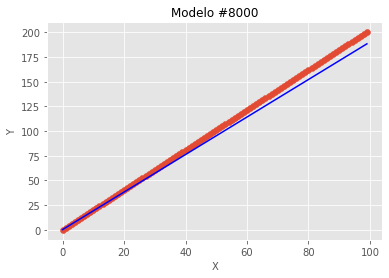

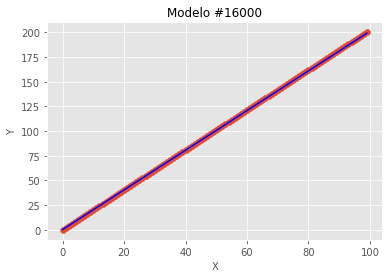

In [43]:
univ_linear_reg.model_plot(modelos, 8000)

## Entrenando modelos de regresión - con OverallQual

In [73]:
train_x = train[['OverallQual','1stFlrSF']]
train_y = train['SalePrice']

In [ ]:
m1 = univ_linear_reg(np.array(train_x['OverallQual']), np.array(train_y), 1000000,500000,0.001)
m1_modelos, m1_errores = model.trained_models()    

Iteración:  0
Error:  19532158225.18737



In [ ]:
univ_linear_reg.error_plot(m1_errores)

In [ ]:
univ_linear_reg.model_plot(m1_modelos, 8000)

## Entrenando modelos de regresión - con 1stFlrSF